# Example Comparison Code

In [84]:
import numpy as np
import json
import os
import drjit as dr
import mitsuba as mi
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

mi.set_variant("llvm_ad_rgb_double")

In [85]:
def relative_diff(a, b):
    return (a - b) / b

def simple_diff(a, b):
    return a - b

def abs_diff(a, b):
    return np.abs(a - b)

def sph_to_eucl(theta, phi):
    st, ct = dr.sincos(theta)
    sp, cp = dr.sincos(phi)
    return mi.Vector3f(cp * st, sp * st, ct)

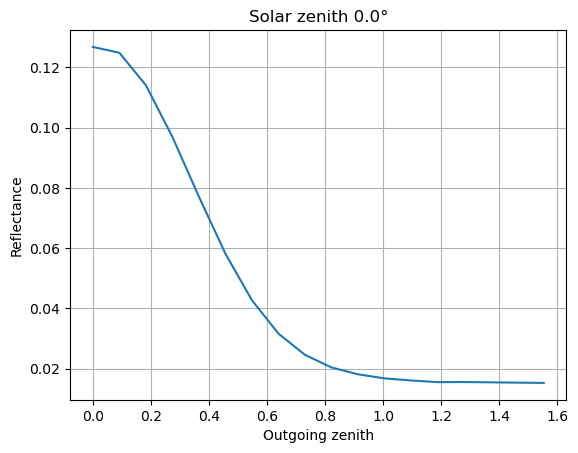

In [86]:
wind_speeds = 10
wind_azimuth = 0

data_file = f'data/data_{wind_speed}ms.json'
data = None

# Load data
with open(data_file, 'r') as f:
    data = json.load(f)

'''
Data is stored in the following way:
{
    "solar_zenith_1": {
        "outgoing_zenith_1": "reflectance",
        "outgoing_zenith_2": "reflectance",
        ...
    },
}
'''

# Example visual of solar zenith 0.0 with view zenith 0.0
example_solar_zenith = 0.0

example_data = data[str(example_solar_zenith)]
example_outgoing_zeniths = list(map(float, example_data.keys()))
#example_outgoing_reflectances = list(map(float, example_data.values()))

example_foams = []
example_glints = []
example_waters = []
example_totals = []
example_foam_percents = []
example_glint_percents = []
example_water_percents = []

for zenith in example_outgoing_zeniths:
    zenith_key = str(zenith)
    foam = example_data[zenith_key]['foam']
    glint = example_data[zenith_key]['glint']
    water = example_data[zenith_key]['water']
    total = example_data[zenith_key]['total']
    foam_percent = foam / total
    glint_percent = glint / total
    water_percent = water / total

    example_foams.append(foam)
    example_glints.append(glint)
    example_waters.append(water)
    example_totals.append(total)
    example_foam_percents.append(foam_percent)
    example_glint_percents.append(glint_percent)
    example_water_percents.append(water_percent)

# Create a plot
fig, ax = plt.subplots()
im = ax.plot(example_outgoing_zeniths, example_totals)
ax.set(xlabel='Outgoing zenith', ylabel='Reflectance',
         title=f'Solar zenith {round(np.rad2deg(example_solar_zenith), 2)}°')
ax.grid()
plt.show()


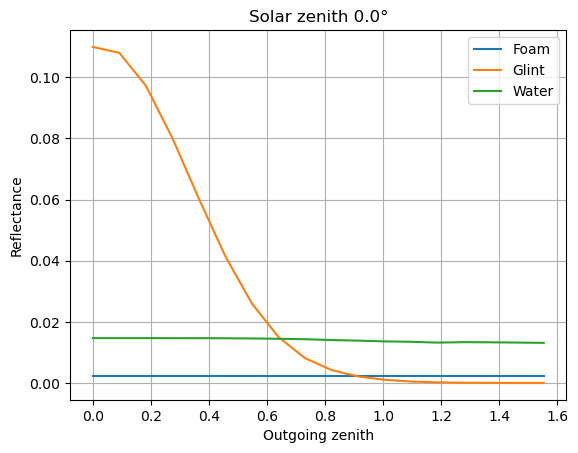

In [87]:
# Foam, glint, water

fig, ax = plt.subplots()

ax.plot(example_outgoing_zeniths, example_foams, label='Foam')
ax.plot(example_outgoing_zeniths, example_glints, label='Glint')
ax.plot(example_outgoing_zeniths, example_waters, label='Water')

ax.set(xlabel='Outgoing zenith', ylabel='Reflectance',
            title=f'Solar zenith {round(np.rad2deg(example_solar_zenith), 2)}°')
ax.grid()
ax.legend()


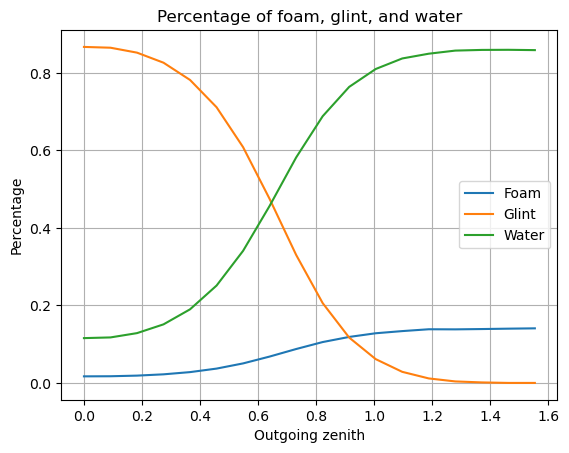

In [88]:
# Percentage of foam, glint, and water
fig, ax = plt.subplots()

ax.plot(example_outgoing_zeniths, example_foam_percents, label='Foam')
ax.plot(example_outgoing_zeniths, example_glint_percents, label='Glint')
ax.plot(example_outgoing_zeniths, example_water_percents, label='Water')

ax.set(xlabel='Outgoing zenith', ylabel='Percentage',
            title=f'Percentage of foam, glint, and water')
ax.grid()
plt.legend()
plt.show()


In [89]:
# Create a mitsuba scene to create similar data
# Create a surface interaction
si = dr.zeros(mi.SurfaceInteraction3f)

# Create the solar direction. Data was generated at a solar zenith of 0 radians
si.wi = sph_to_eucl(example_solar_zenith, dr.deg2rad(0))

# Since we want to compare, we create a simple meshgrid of len(outgoing_zeniths) x 1
resolution = len(example_outgoing_zeniths)
zeniths_o, azimuths_o = dr.meshgrid(
    dr.linspace(mi.Float, np.deg2rad(0), np.deg2rad(89), resolution),

    # Data was generated with a viewing azimuth of π radians
    dr.linspace(mi.Float, np.pi, np.pi, 1)
)

# Construct the outgoing directions
wo = sph_to_eucl(zeniths_o, azimuths_o)

In [90]:
# BSDF Construction where we keep the same parameters as the generated data
bsdf = mi.load_dict({
    'type': 'oceanic_legacy',
    'wavelength': 0.5,
    'wind_speed': wind_speed,
    'wind_direction': wind_azimuth,
    'chlorinity': 19,
    'pigmentation': 0.3
})
bsdf

OceanicLegacy[
  wavelength = 0.5
  wind_speed = 10
  wind_direction = 0
  chlorinity = 19
  pigmentation = 0.3
]

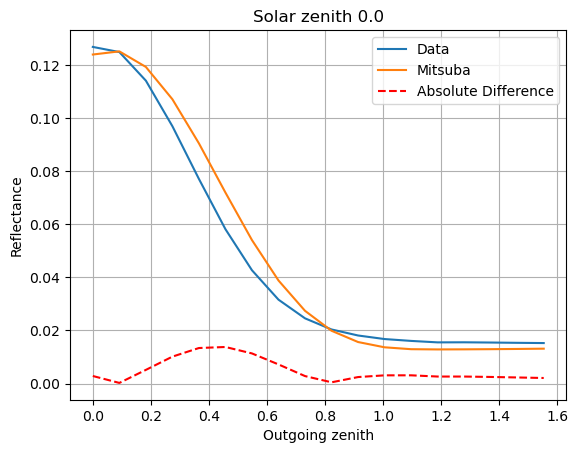

In [91]:
# Evaluate the BSDF
bsdf_values = bsdf.eval(mi.BSDFContext(), si, wo)
bsdf_array = np.array(bsdf_values)

# Extract one channel
bsdf_array = bsdf_array[:, 0]

# Compute the difference between the data and the Mitsuba BSDF
example_outgoing_reflectances = np.array(example_totals)
reflectance_diff = abs_diff(example_outgoing_reflectances, bsdf_array)

# Plot against the outgoing zeniths
fig, ax = plt.subplots()
im = ax.plot(example_outgoing_zeniths, example_outgoing_reflectances, label='Data')
im = ax.plot(zeniths_o, bsdf_array, label='Mitsuba')
im = ax.plot(zeniths_o, reflectance_diff, label='Absolute Difference', linestyle='--', color='red')
ax.set(xlabel='Outgoing zenith', ylabel='Reflectance',
         title=f'Solar zenith {np.rad2deg(example_solar_zenith)}')
ax.grid()
ax.legend()
plt.show()

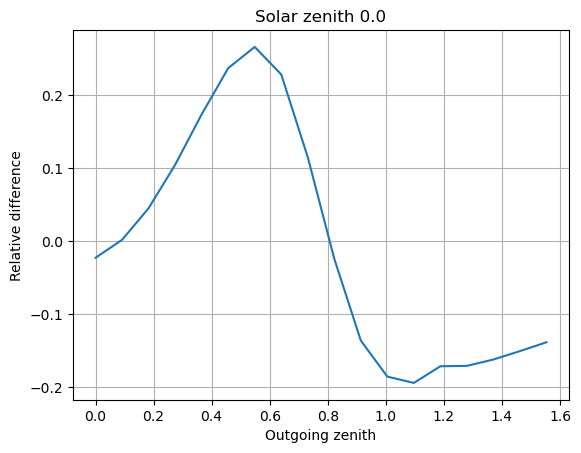

In [92]:
# Relative difference 
relative_diffs = relative_diff(bsdf_array, example_outgoing_reflectances)

fig, ax = plt.subplots()
im = ax.plot(zeniths_o, relative_diffs)
ax.set(xlabel='Outgoing zenith', ylabel='Relative difference',
         title=f'Solar zenith {np.rad2deg(example_solar_zenith)}')
ax.grid()
plt.show()